**CPD with Two core updates**
    

Anh-Huy Phan

In [166]:
!pip install timm
# !pip install detectors
import timm
# import detectors

In [1]:
import numpy as np
from tensorly.tenalg import khatri_rao
from tensorly.tenalg.core_tenalg import mttkrp

from tensorly.random import random_cp
import matplotlib.pyplot as plt
from tensorly.decomposition._cp import initialize_cp
from tensorly.cp_tensor import (
    CPTensor,
    unfolding_dot_khatri_rao,
    cp_norm,
    cp_normalize,
    validate_cp_rank,
    cp_to_tensor
)
from scipy.sparse.linalg import svds
import time
from tqdm import tqdm

import tensorly.decomposition


In [165]:
#-------------------------------------------------------------------------------
# ADMM routine
#-------------------------------------------------------------------------------
 
import numpy as np
import scipy.linalg
import scipy.sparse.linalg

def linreg_krp(Ymn, Phi, rho, szXnm, X0,maxiters,T=None, verbose = False):
    # ADMM
    #   solve min||Y-Phi*Z^T||^2_f  
    #   s.t. Z= X 
    #   """
    # szY(1) = [I1 I2 R]
    R = szXnm[2]
    Q = scipy.linalg.inv(Phi.T @ Phi + rho * np.eye(R))
    B = Ymn.T @ Phi
    
    if T is None:
      T = np.zeros([szXnm[0]*szXnm[1],R])
      
    normY = np.linalg.norm(Ymn,'fro')**2
    
    X = X0 
    Z = X
    f0 = np.linalg.norm(Ymn - Phi @ X.T, 'fro')**2/ normY
    loss_history = [] 
    
    primal_residual_history = []
    # Define the parameters of the rule
    mu = 10 # Residual ratio threshold
    tau = 2 # Rho scaling factor

    
    for kiter in range(maxiters):
        Z_old = Z
          
        # Update Z
        Z = np.matmul(B + rho * (X + T), Q)
        
        # Update X
        D = Z - T
        D = D.reshape(szXnm[1],szXnm[0],szXnm[2])
        F1 = np.zeros((szXnm[0], R))
        F2 = np.zeros((szXnm[1], R)) 
        S = np.zeros((R))
        for r in range(R):
          u, s, v = svds(D[:, :, r].T, k=1)
        
          F1[:, r:r+1] = u
          F2[:, r:r+1] = v.T
          S[r] = s
          #X[:, r:r+1] = np.kron(v.T, u) * s
        
        X = khatri_rao([F2,F1 @ np.diag(S)])
        
        # update T
        T = T + X - Z
        
        # Compute the objective function value
        loss = np.linalg.norm(Ymn - Phi @ Z.T, 'fro')**2/ normY # f(Z) + i(X) 
        
        # Compute the primal residual
        r = Z - X
        # dual residual
        s = rho * (Z - Z_old)
        # Compute the primal and dual residual norms
        norm_r = np.linalg.norm(r,'fro')
        norm_s = np.linalg.norm(s,'fro')
         
        loss_history.append(loss)
        primal_residual_history.append(norm_r/ np.linalg.norm(Z,'fro'))
 
        if verbose== True:
            print(f'kiter {kiter} | f = {loss} | d(Z,X) {primal_residual_history[-1]} | rho {rho}') 
        
        if (kiter>5) and (loss<=1e-6) and (primal_residual_history[-1]<=1e-5):
            break 
        
    return X, Z, F1, F2,S,loss_history, primal_residual_history, T, rho


In [3]:
def solver(Y,R,Y_hat,rho,maxoutiters,maxiters,min_rho_stable):
    # maxoutiters = 100
    # rho = 1e1
    # maxiters = 10
    modes = len(Y.shape)
    szY = np.array(Y.shape) 
 
    normY = np.linalg.norm(Y.reshape(-1))**2
    mainloss_history = []

    rho_stable = rho
    counter = 0
    flag = 0

    for kiter in range(maxoutiters):
    
        for n in range(modes-1):
            m = n+1 # can change the mode m 
                           
            modes_1 = np.sort([n, m])
            modes_2 = np.sort(np.setdiff1d(np.arange(modes), modes_1))
             
            sz2 = np.prod(szY[modes_2])
            sz1 = np.prod(szY[modes_1])
            
            # unfolding mode-(n,m)    
            Y_nm = np.transpose(Y, axes = [*modes_2, *modes_1])
            # print(Y_nm.shape)
            Y_nm = Y_nm.reshape(sz2, sz1,  order = 'F')
            
            szXnm = [szY[modes_1[0]], szY[modes_1[1]], R]
    
            # initialize X0
            U_in = Y_hat.factors[modes_1[0]].copy()
            V_in = Y_hat.factors[modes_1[1]].copy()
            X0 = khatri_rao([V_in, U_in@np.diag(Y_hat.weights)])
    
            # Compute Phi
            Factorx2 = [Y_hat.factors[i] for i in modes_2[::-1]]
            Phi = khatri_rao(Factorx2)                      
    
            # solve sub-problem
            fcurr = np.linalg.norm(Y_nm - Phi @ X0.T, 'fro')**2/ normY

            while 1:
                X, Z, Unew, Vnew, Snew, loss_history, dZ, T , rhonew = linreg_krp(Y_nm, Phi, rho, szXnm, X0,maxiters,T=None,verbose = False)

                if loss_history[-1]> fcurr*10 :
                    # fail case
                    rho = rho*1.1
                else:
                    break
                
                
            
            # reject the update if the loss increases
            # if (kiter>2) and (loss_history[-1]>mainloss_history[-1]+np.abs(mainloss_history[-2]-mainloss_history[-1])*.2):
            #     continue 
            # else:
            Y_hat.factors[modes_1[0]] = Unew
            Y_hat.factors[modes_1[1]] = Vnew
            Y_hat.weights = Snew                
    
            print(f'kiter {kiter: 2.2f} | f = {loss_history[-1]:2.4e} | d(Z,X) {dZ[-1]:2.4e} |  rho {rho_stable: .4e}')

            mainloss_history.append(loss_history[-1])

             # If the loss function value is smaller than the previous 10 values, increment the counter by one and set the flag to True
            if (len(mainloss_history)>5) and (kiter > 1) and (loss_history[-1] <= np.min(mainloss_history[-5:])):
                counter += 1
                flag = 1
            else:
                counter = 0
                flag = 0
    
            # If the counter reaches 10 and the error is smaller than 1e-6, reduce rho by a factor of 0.9 or 0.95, and reset the counter to zero
            if (counter == 2) and (dZ[-1] < 1e-6):
                rho = rho * 0.95
                counter = 0
            
            # If the loss function value is larger than the previous value, reduce the counter by one
            if (len(mainloss_history)>2) and (kiter > 1) and (loss_history[-1] > mainloss_history[-2]):
                counter -= 1
            
            # If the counter is negative, increase rho by a small amount (e.g., 0.1) until it reaches rho_stable, and reset the counter to zero
            if counter < 0:
                rho = min(rho + 0.1, rho_stable)
                counter = 0
            
            # Update rho_stable to be the minimum of rho and rho_stable only when the flag is True
            if flag == 1:
                rho_stable = max(min_rho_stable,min(rho, rho_stable) )
                
        if (kiter > 5) and (mainloss_history[-1]<=1e-6) and (dZ[-1]<=1e-4):
            break
 
    return Y_hat, mainloss_history



In [86]:
def cp_sensitivity(CPtensor):
 
    N = len(CPtensor.factors)
    CPtensor = tensorly.cp_tensor.cp_normalize(CPtensor)
    Factors = [x @ np.diag(pow(CPtensor.weights,1/N)) for x in CPtensor.factors]
    C = [x.T @ x  for x in Factors]
    C = np.array(C)
    sensitivity = 0
    for n in range(N):
        # Create a numpy array of numbers from 1 to N
        array = np.arange(0, N)
         
        # Remove the element at index n-1
        array = np.delete(array,n-1)
        sensitivity = sensitivity+ np.trace(np.prod(C[array,:,:],axis = 0))
        
    return sensitivity

**Example for Resnet Conv Weight**

In [167]:
#resnet = timm.create_model("resnet18_cifar10", pretrained=True)
def get_pretrained_resnet():
    model = timm.create_model("resnet18", pretrained=False)

    # override model
    model.conv1 = nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    model.maxpool = nn.Identity()  # type: ignore
    model.fc = nn.Linear(512,  10)

    model.load_state_dict(
                torch.hub.load_state_dict_from_url(
                        "https://huggingface.co/edadaltocg/resnet18_cifar10/resolve/main/pytorch_model.bin",
                        map_location="cpu",
                        file_name="resnet18_cifar10.pth",
                )
    )
    return model

In [18]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch import nn

In [22]:
device = 'cpu' if not torch.cuda.is_available() else 'cuda'
print(device)
torch.set_default_device(device)

resnet = get_pretrained_resnet().to('cpu')

weights = resnet.layer1[0].conv1.weight.clone()
szW = weights.shape
weights = weights.reshape([szW[0],szW[1],szW[2]*szW[3]])
weights = weights.permute(0,2,1).detach().to(device)

weights.shape

cuda


torch.Size([64, 9, 64])

In [23]:
Y = weights.cpu().numpy()

R = 30
weights_init, factors_init = initialize_cp(Y, init='svd', rank=R)
Y_hat = CPTensor((weights_init, factors_init))

Y_hat.shape

(64, 9, 64)

kiter  0.00 | f = 5.4993e-01 | d(Z,X) 1.4451e-15 |  rho  1.0000e+00
kiter  0.00 | f = 4.2406e-01 | d(Z,X) 1.8172e-05 |  rho  1.0000e+00
kiter  1.00 | f = 2.3842e-01 | d(Z,X) 4.3730e-04 |  rho  1.0000e+00
kiter  1.00 | f = 1.9441e-01 | d(Z,X) 2.7497e-06 |  rho  1.0000e+00
kiter  2.00 | f = 1.7556e-01 | d(Z,X) 6.7263e-05 |  rho  1.0000e+00
kiter  2.00 | f = 1.6605e-01 | d(Z,X) 9.5970e-07 |  rho  1.0000e+00
kiter  3.00 | f = 1.5896e-01 | d(Z,X) 2.4018e-05 |  rho  1.0000e+00
kiter  3.00 | f = 1.5338e-01 | d(Z,X) 2.2478e-06 |  rho  1.0000e+00
kiter  4.00 | f = 1.4846e-01 | d(Z,X) 4.0198e-05 |  rho  1.0000e+00
kiter  4.00 | f = 1.4444e-01 | d(Z,X) 5.6671e-07 |  rho  1.0000e+00
kiter  5.00 | f = 1.4105e-01 | d(Z,X) 1.7767e-05 |  rho  1.0000e+00
kiter  5.00 | f = 1.3828e-01 | d(Z,X) 5.6045e-07 |  rho  1.0000e+00
kiter  6.00 | f = 1.3595e-01 | d(Z,X) 1.1352e-05 |  rho  1.0000e+00
kiter  6.00 | f = 1.3409e-01 | d(Z,X) 4.4579e-07 |  rho  1.0000e+00
kiter  7.00 | f = 1.3255e-01 | d(Z,X) 1.2322e-05

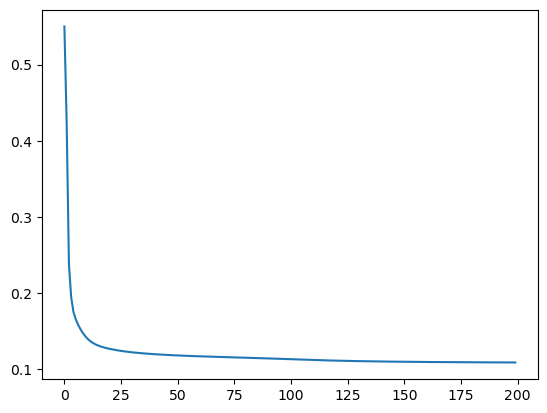

In [24]:
maxoutiters = 100
rho = 1e0
min_rho_stable = 1
maxiters = 100

Y_hat, err = solver(Y,R,Y_hat,rho,maxoutiters,maxiters,min_rho_stable)

plt.plot(np.array(err).flatten())
 


kiter  0.00 | f = 1.0920e-01 | d(Z,X) 5.5239e-06 |  rho  1.0000e+00
kiter  0.00 | f = 1.0919e-01 | d(Z,X) 2.5764e-06 |  rho  1.0000e+00
kiter  1.00 | f = 1.0918e-01 | d(Z,X) 5.5210e-06 |  rho  1.0000e+00
kiter  1.00 | f = 1.0916e-01 | d(Z,X) 2.5750e-06 |  rho  1.0000e+00
kiter  2.00 | f = 1.0916e-01 | d(Z,X) 5.5182e-06 |  rho  1.0000e+00
kiter  2.00 | f = 1.0914e-01 | d(Z,X) 2.5741e-06 |  rho  1.0000e+00
kiter  3.00 | f = 1.0913e-01 | d(Z,X) 5.5155e-06 |  rho  1.0000e+00
kiter  3.00 | f = 1.0912e-01 | d(Z,X) 2.5736e-06 |  rho  1.0000e+00
kiter  4.00 | f = 1.0911e-01 | d(Z,X) 5.5128e-06 |  rho  1.0000e+00
kiter  4.00 | f = 1.0910e-01 | d(Z,X) 2.5734e-06 |  rho  1.0000e+00
kiter  5.00 | f = 1.0909e-01 | d(Z,X) 5.5103e-06 |  rho  1.0000e+00
kiter  5.00 | f = 1.0908e-01 | d(Z,X) 2.5736e-06 |  rho  1.0000e+00
kiter  6.00 | f = 1.0908e-01 | d(Z,X) 5.5077e-06 |  rho  1.0000e+00
kiter  6.00 | f = 1.0906e-01 | d(Z,X) 2.5741e-06 |  rho  1.0000e+00
kiter  7.00 | f = 1.0906e-01 | d(Z,X) 5.5053e-06

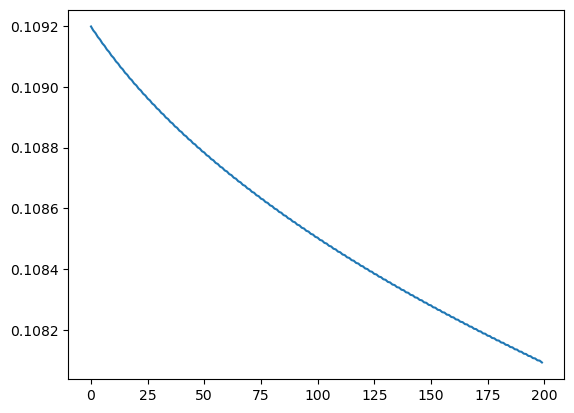

In [25]:
rho = 1
min_rho_stable = 1
Y_hat, err = solver(Y,R,Y_hat,rho,maxoutiters,100,min_rho_stable)


plt.plot(np.array(err).flatten())


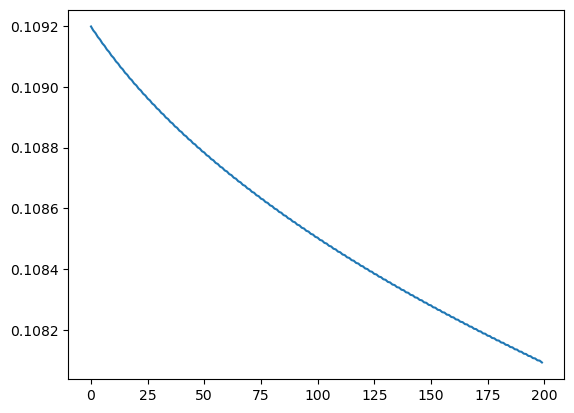

In [26]:
plt.plot(np.array(err).flatten())


kiter  0.00 | f = 1.0809e-01 | d(Z,X) 5.1971e-06 |  rho  1.0000e+00
kiter  0.00 | f = 1.0809e-01 | d(Z,X) 2.8434e-06 |  rho  1.0000e+00
kiter  1.00 | f = 1.0808e-01 | d(Z,X) 5.1940e-06 |  rho  1.0000e+00
kiter  1.00 | f = 1.0808e-01 | d(Z,X) 2.8451e-06 |  rho  1.0000e+00
kiter  2.00 | f = 1.0808e-01 | d(Z,X) 5.1909e-06 |  rho  1.0000e+00
kiter  2.00 | f = 1.0807e-01 | d(Z,X) 2.8467e-06 |  rho  1.0000e+00
kiter  3.00 | f = 1.0807e-01 | d(Z,X) 5.1879e-06 |  rho  1.0000e+00
kiter  3.00 | f = 1.0806e-01 | d(Z,X) 2.8484e-06 |  rho  1.0000e+00
kiter  4.00 | f = 1.0806e-01 | d(Z,X) 5.1848e-06 |  rho  1.0000e+00
kiter  4.00 | f = 1.0806e-01 | d(Z,X) 2.8500e-06 |  rho  1.0000e+00
kiter  5.00 | f = 1.0806e-01 | d(Z,X) 5.1818e-06 |  rho  1.0000e+00
kiter  5.00 | f = 1.0805e-01 | d(Z,X) 2.8515e-06 |  rho  1.0000e+00
kiter  6.00 | f = 1.0805e-01 | d(Z,X) 5.1787e-06 |  rho  1.0000e+00
kiter  6.00 | f = 1.0804e-01 | d(Z,X) 2.8531e-06 |  rho  1.0000e+00
kiter  7.00 | f = 1.0804e-01 | d(Z,X) 5.1756e-06

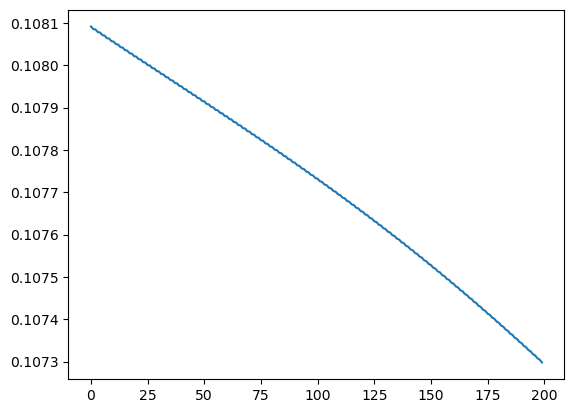

In [168]:
rho = 1
min_rho_stable = 1
Y_hat, err = solver(Y,R,Y_hat,rho,maxoutiters,100,min_rho_stable)

plt.plot(np.array(err).flatten())

In [30]:

from tensorly.decomposition import parafac
from tensorly.cp_tensor import KruskalTensor



In [50]:
# ALS algorithm 
Factor_cp = parafac(Y,R,maxoutiters*4, init = 'svd',verbose=1)


reconstruction error=0.8078480958161594
iteration 1, reconstruction error: 0.6105109208612678, decrease = 0.19733717495489156, unnormalized = 2.0437779343286993
iteration 2, reconstruction error: 0.5032965974255073, decrease = 0.10721432343576054, unnormalized = 1.6848617200653002
iteration 3, reconstruction error: 0.4579784518426547, decrease = 0.045318145582852576, unnormalized = 1.5331523520555237
iteration 4, reconstruction error: 0.4368914101898416, decrease = 0.021087041652813054, unnormalized = 1.4625602807957814
iteration 5, reconstruction error: 0.42261029640484254, decrease = 0.014281113784999078, unnormalized = 1.4147520856692424
iteration 6, reconstruction error: 0.41273564319743145, decrease = 0.0098746532074111, unnormalized = 1.381695185874585
iteration 7, reconstruction error: 0.4056428420367873, decrease = 0.0070928011606441466, unnormalized = 1.3579509578692033
iteration 8, reconstruction error: 0.40016144821939587, decrease = 0.005481393817391433, unnormalized = 1.33

In [114]:
Y_als = CPTensor(Factor_cp)
Y_als = cp_to_tensor(Y_als) 
err_als = np.linalg.norm((Y_als-Y).reshape(-1))/np.linalg.norm(Y.reshape(-1))
print(err_als**2)

Y_als = CPTensor(Factor_cp)
Y_als = cp_normalize(Y_als)
ss_als = cp_sensitivity(Y_als)
print(ss_als)

 

0.11316385870537715
2513.4064331054688


In [169]:
Y2cu = cp_to_tensor(Y_hat) 
err_2cu = np.linalg.norm((Y2cu-Y).reshape(-1))/np.linalg.norm(Y.reshape(-1))
print(err_2cu**2) 

Y_hat = cp_normalize(Y_hat)
ss_2cup = cp_sensitivity(Y_hat)
print(ss_2cup)

 

0.10729527708118403
360.7612738978603


Text(0, 0.5, 'Weight')

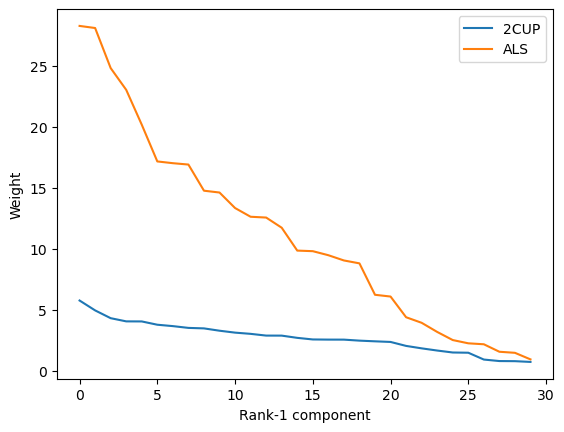

In [170]:
plt.plot(np.sort(Y_hat.weights)[::-1])
plt.plot(np.sort(Y_als.weights)[::-1])
plt.legend(['2CUP', 'ALS'])
plt.xlabel('Rank-1 component')
plt.ylabel('Weight')

In [117]:
import pandas as pd


In [173]:
summary = pd.DataFrame([err_2cu,err_als])
summary.index = ['2CUP','ALS']
summary.columns = ['RelError']

summary.insert(1,"Sensitivity",[ss_2cup, ss_als])


# Perturb the estimated tensor by noise 0.01 sigma
# and check the relative error of the perturbed tensor

sigma = 0.01 # standard deviation of noise

Factors_noisy = [x + np.random.randn(x.shape[0],x.shape[1])*sigma for x in Y_hat.factors] # add noise to each tensor
weights_noisy = Y_hat.weights + np.random.randn(R)*sigma

Ypt = cp_to_tensor(CPTensor((weights_noisy,Factors_noisy)))
err_2cu_pb = np.linalg.norm((Ypt-Y).reshape(-1))/np.linalg.norm(Y.reshape(-1))


Factors_noisy = [x + np.random.randn(x.shape[0],x.shape[1])*sigma for x in Factor_cp.factors] # add noise to each tensor
weights_noisy = Factor_cp.weights + np.random.randn(R)*sigma

Ypt = cp_to_tensor(CPTensor((weights_noisy,Factors_noisy)))
err_als_pb = np.linalg.norm((Ypt-Y).reshape(-1))/np.linalg.norm(Y.reshape(-1))


summary.insert(1,"RelErr (perturbed)",[err_2cu_pb,err_als_pb])

summary

,RelError,RelErr (perturbed),Sensitivity
2CUP,0.327560,0.669499,360.761274
ALS,0.336398,4.437504,2513.406433


In [172]:
# save resutls
import pickle
# Create a file object in write and binary mode

filename = f"result_2cup_resnet18_layer1_conv1.pkl"

with open (filename, 'wb') as f:
    # Store the list object to the file using the dump method
    data  = { 'summary ' : summary, 'factors_2cup'  : Y_hat.factors, 'weights_2cup' : Y_hat.weights, 'factors_als' :  Factor_cp.factors,'weights_als' : Factor_cp.weights}
    pickle.dump(data,f,pickle.HIGHEST_PROTOCOL)